<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint6/Module2/JDS_SHR_222_guided_project_notes_RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BloomTech Data Science

---

# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [1]:
%%capture

!pip install category_encoders==2.*

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# # mounting your google drive on colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# #change your working directory, if you want to or have already saved your kaggle dataset on google drive.
# %cd /content/gdrive/My Drive/Kaggle
# # update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# # List all files in your Kaggle folder on your google drive.
# !ls

In [6]:
#https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/main/data/kaggle/test_features.csv

# I. Wrangle Data

In [24]:
DATAPATH = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/master/data/kaggle/"

def wrangle(fm_path, tv_path=None): # tv means target vector, if it's not specified, we're only working with the test set
                                    # fm means feature matrix
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')     # merging train features and train labels file
  else:                                                 # only working with test set, reading one csv file
    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index # change 15 to 100!!!!
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df

# add the datapath if needed
df = wrangle(fm_path = '/content/train_features.csv',
             tv_path = '/content/train_labels.csv')

X_test = wrangle(fm_path = '/content/test_features.csv')

In [14]:
# X_test is one column short, without the status_group target vector column

In [25]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

In [26]:
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,NaN
14530,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,NaN
62607,10.0,1675.0,35.488289,-4.242048,NaN,Internal,Manyara,21,1.0,148.0,...,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,5.0
46053,NaN,NaN,33.140828,-9.059386,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,...,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,NaN
47083,50.0,1109.0,34.217077,-4.430529,NaN,Internal,Singida,13,1.0,235.0,...,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,2.0


# II. Split Data

## Split TV from FM

In [27]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**.

In [29]:
# calculate it based on majority class
print('baseline accuracy:', y_train.value_counts(normalize=True).max())

baseline accuracy: 0.5425489938182296


# IV. Build Model(s)

- Missing values
- Categorical values

**First Model:** Decision Trees

In [30]:
X_train.head() # lots of categorical data that need encoder

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
68310.0,NaN,NaN,32.757280,-2.532955,NaN,Lake Victoria,Mwanza,19,5.0,NaN,...,never pay,soft,good,dry,shallow well,shallow well,groundwater,hand pump,hand pump,NaN
64252.0,NaN,1326.0,30.902357,-3.635665,NaN,Lake Tanganyika,Kigoma,16,1.0,300.0,...,unknown,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,9.0
27999.0,NaN,339.0,39.493110,-10.863318,NaN,Ruvuma / Southern Coast,Mtwara,9,4.0,1.0,...,never pay,soft,good,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,31.0
49040.0,NaN,1803.0,36.799547,-3.172507,NaN,Internal,Arusha,2,7.0,120.0,...,unknown,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,6.0
54159.0,NaN,NaN,30.814661,-2.431693,NaN,Lake Victoria,Kagera,18,30.0,NaN,...,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN


- We use Ordinal Encoder in Decision Tree and One Hot Encoder in Linear Regression or any model that use distance to calculate residues and errors
- For Decision Tree, we don't care about the distances, so it's OK to use Ordinal Encoder where the order numbers 1, 2, 3, etc. don't matter as much. If we use OneHotEncoder, a lot of the numbers will be 0s, and it will cause the tree to get imbalanced because it will just keep going down the x=0 y=0 z=0 path.

In [31]:
# Decision Tree
model_dt = make_pipeline(
    OrdinalEncoder(),  # we use this instead of OneHotEncoder because we don't care about distances so it's ok to have the categories ordered by numbers 1, 2, 3, etc.
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42)
)

model_dt.fit(X_train, y_train);

In [33]:
# Plotting the tree

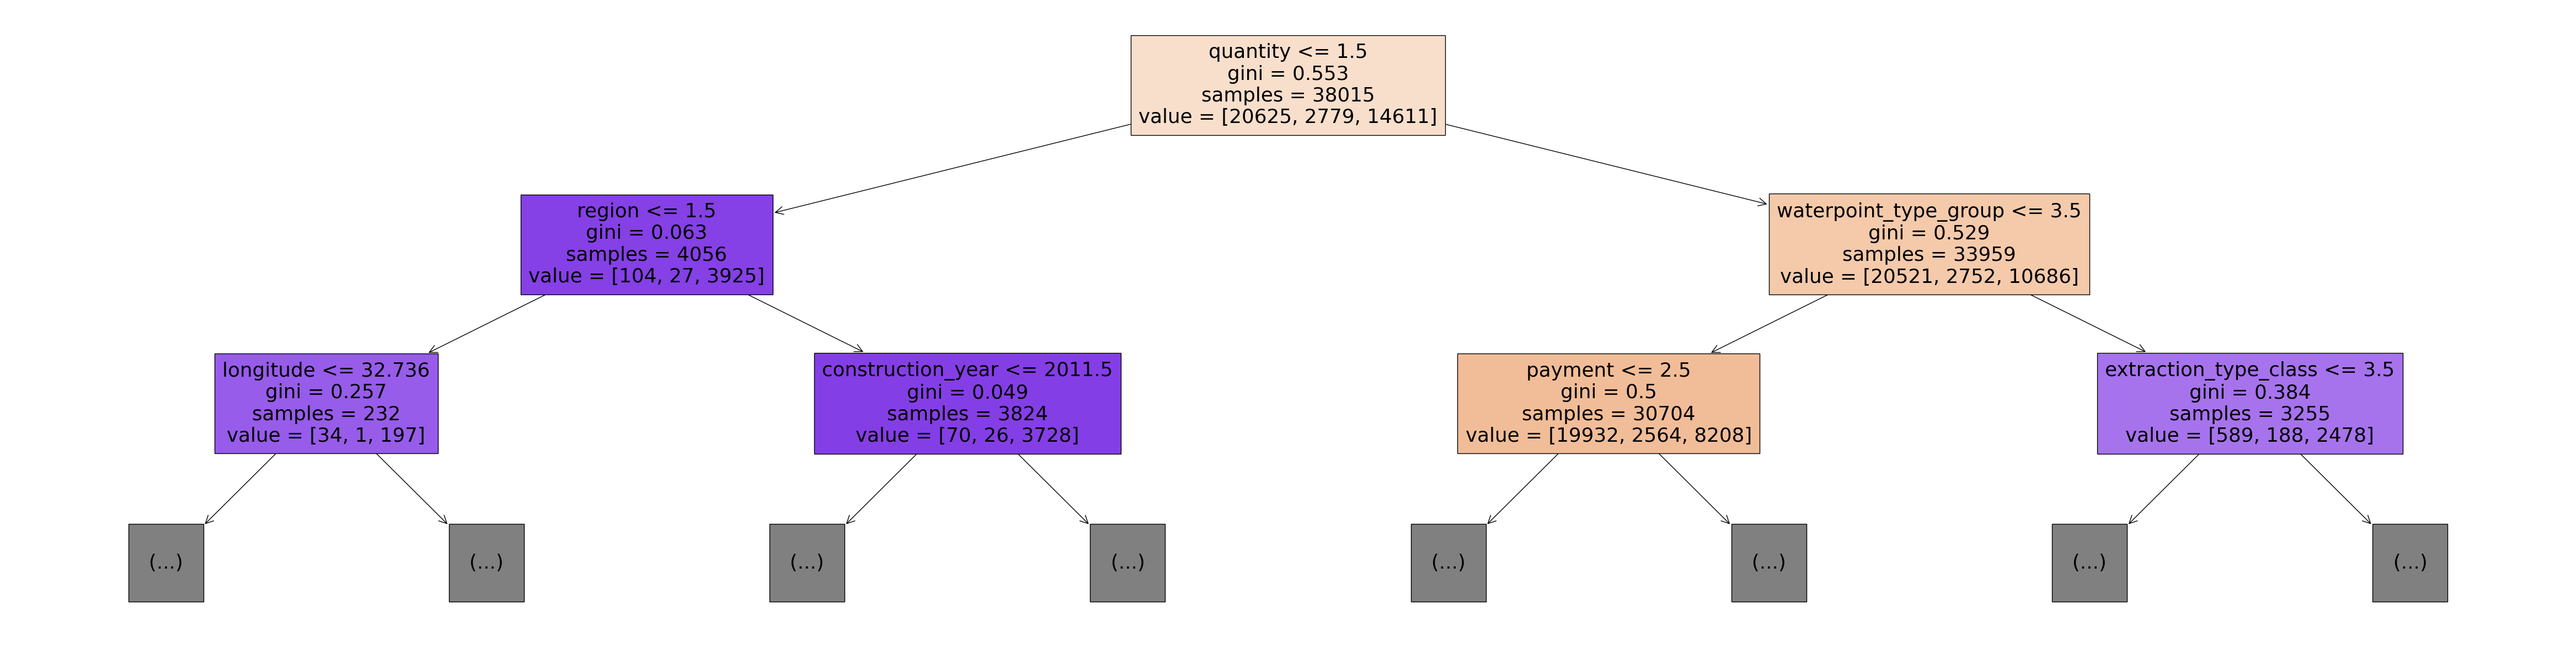

In [32]:
plt.figure(figsize=(60,15));
plot_tree(model_dt.named_steps['decisiontreeclassifier'],
         max_depth=2,
         feature_names=X_train.columns,
         filled=True
         );

In [35]:
# find out the depth of the tree
model_dt.named_steps['decisiontreeclassifier'].get_depth()

37

**Second Model:** Random Forest

- bunch of decision trees grouped together using BOOTSRAP AGGREGATION aka BAGGING, types of ENSEMBLE METHODS
- ensemble method is a group of models that work together and combine their outputs to arrive at one optimal prediction
- Boostrapping = dividing the training set into subsamples, and each subsample has its own tree. Each tree looks different
- finally a vote of predictions, majority vote, or calculate a mean, will give us the final class
- diversity of trees in the forest makes our model more robust and prevent overfitting
- Random forest can be use on regression as well. Use the RandomForestRegressor instead of the classifier

In [38]:
#Random Forest
model_rf = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'), # NaN values replaced by mean
      RandomForestClassifier(random_state=42, n_jobs=-1) # use all the cores to build our model
)

model_rf.fit(X_train, y_train);

# V. Check Metrics

In [36]:
# for the tree
print('TREE: Training Accuracy:', model_dt.score(X_train, y_train))
print('TREE: Validation Accuracy:', model_dt.score(X_val, y_val))

TREE: Training Accuracy: 0.995475470209128
TREE: Validation Accuracy: 0.7373737373737373


In [40]:
# for random forest
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.9954228593976062
FOREST: Validation Accuracy: 0.7936658249158249


In [41]:
# random forest still overfitting, but at least the model accuracy to generalize has improved!

# VI. Tune Model

Refer to scikit documentation for hyperparameters

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

- n_estimatorsint, default=100 - number of trees in your forest. The more trees, the higher risk of overfitting
- max_samples, when bootstrapping, max sample for each individual tree. If you have more examples in each tree, then there will be overlapping thus decreasing diversity in the forest

In [43]:
train_acc = []
val_acc = []
max_samples_list = np.arange(0.2,1,0.1) # can be an int or float, float will mean the fraction of training set

# model
for sample in max_samples_list:
  model_rf_tune = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=sample) # use all the cores to build our model
)
  # remember to fit it, still within the for loop
  model_rf_tune.fit(X_train, y_train)

  # calculate the respective acc score and store them in a list, and append the scores to the empty lists created
  train_acc.append(model_rf_tune.score(X_train, y_train))
  val_acc.append(model_rf_tune.score(X_val, y_val))

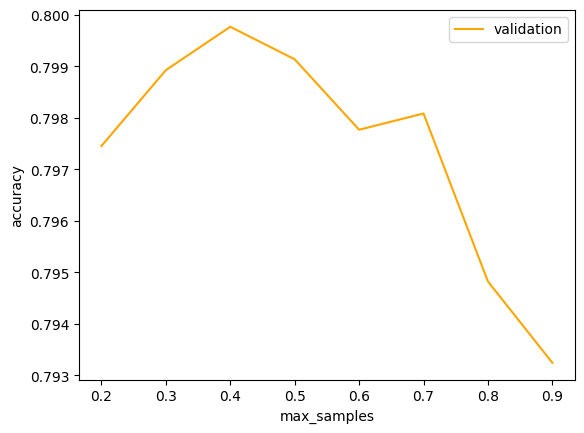

In [45]:
# plt.plot(max_samples_list, train_acc, color='blue', label='training') # turn it off so the the scale is zoomed in for just the validation accuracy
plt.plot(max_samples_list, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# highest accuracy when the max_samples is 0.4

### After using brute force to find the ideal hyperparameter, we're re-running the model and compare accuracy scores.

In [47]:
# Let's tweak our model with max_samples = 0.4
#Random Forest
model_rf = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'), # NaN values replaced by mean
      RandomForestClassifier(random_state=42, n_jobs=-1, max_samples=0.4) # n_jobs=-1 means to use all the cores to build our model
)

model_rf.fit(X_train, y_train);

In [48]:
# for random forest
print('FOREST: Training Accuracy:', model_rf.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rf.score(X_val, y_val))

FOREST: Training Accuracy: 0.9296067341838747
FOREST: Validation Accuracy: 0.7997685185185185


In [49]:
# val acc went from 0.793 to 0.799, also not as overfitting for training data

# VII. Communicate Results

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


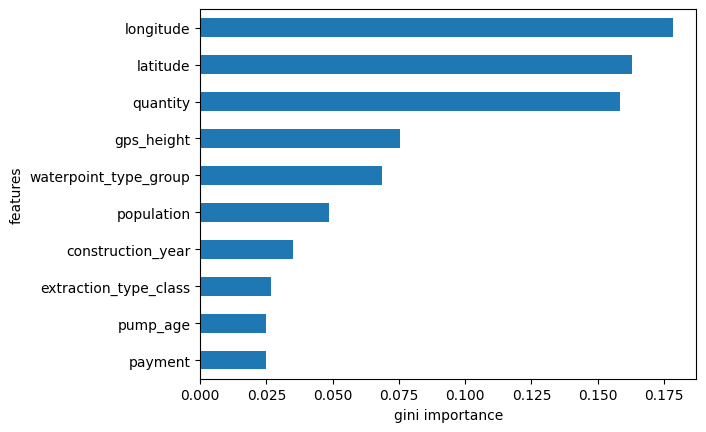

In [50]:
# decision Tree
features = model_dt.named_steps['ordinalencoder'].get_feature_names()  # remember named_steps has to be all lowercase
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

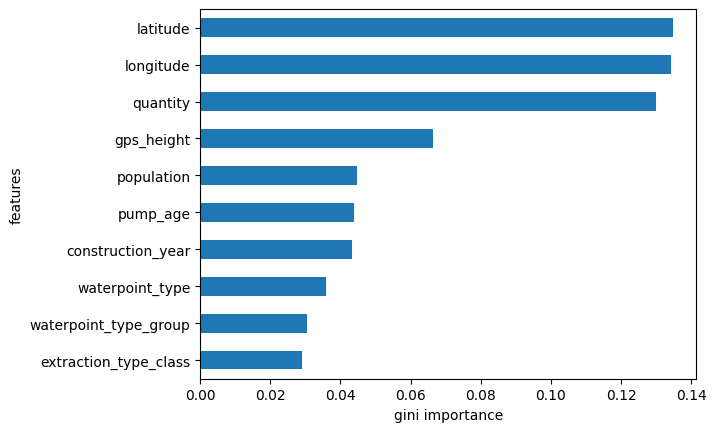

In [52]:
# random forest
features = model_rf.named_steps['ordinalencoder'].get_feature_names()  # remember named_steps has to be all lowercase
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

In [53]:
#first tree in the Random Forest
model_rf.named_steps['randomforestclassifier'].estimators_[0]  # first tree in the forest

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

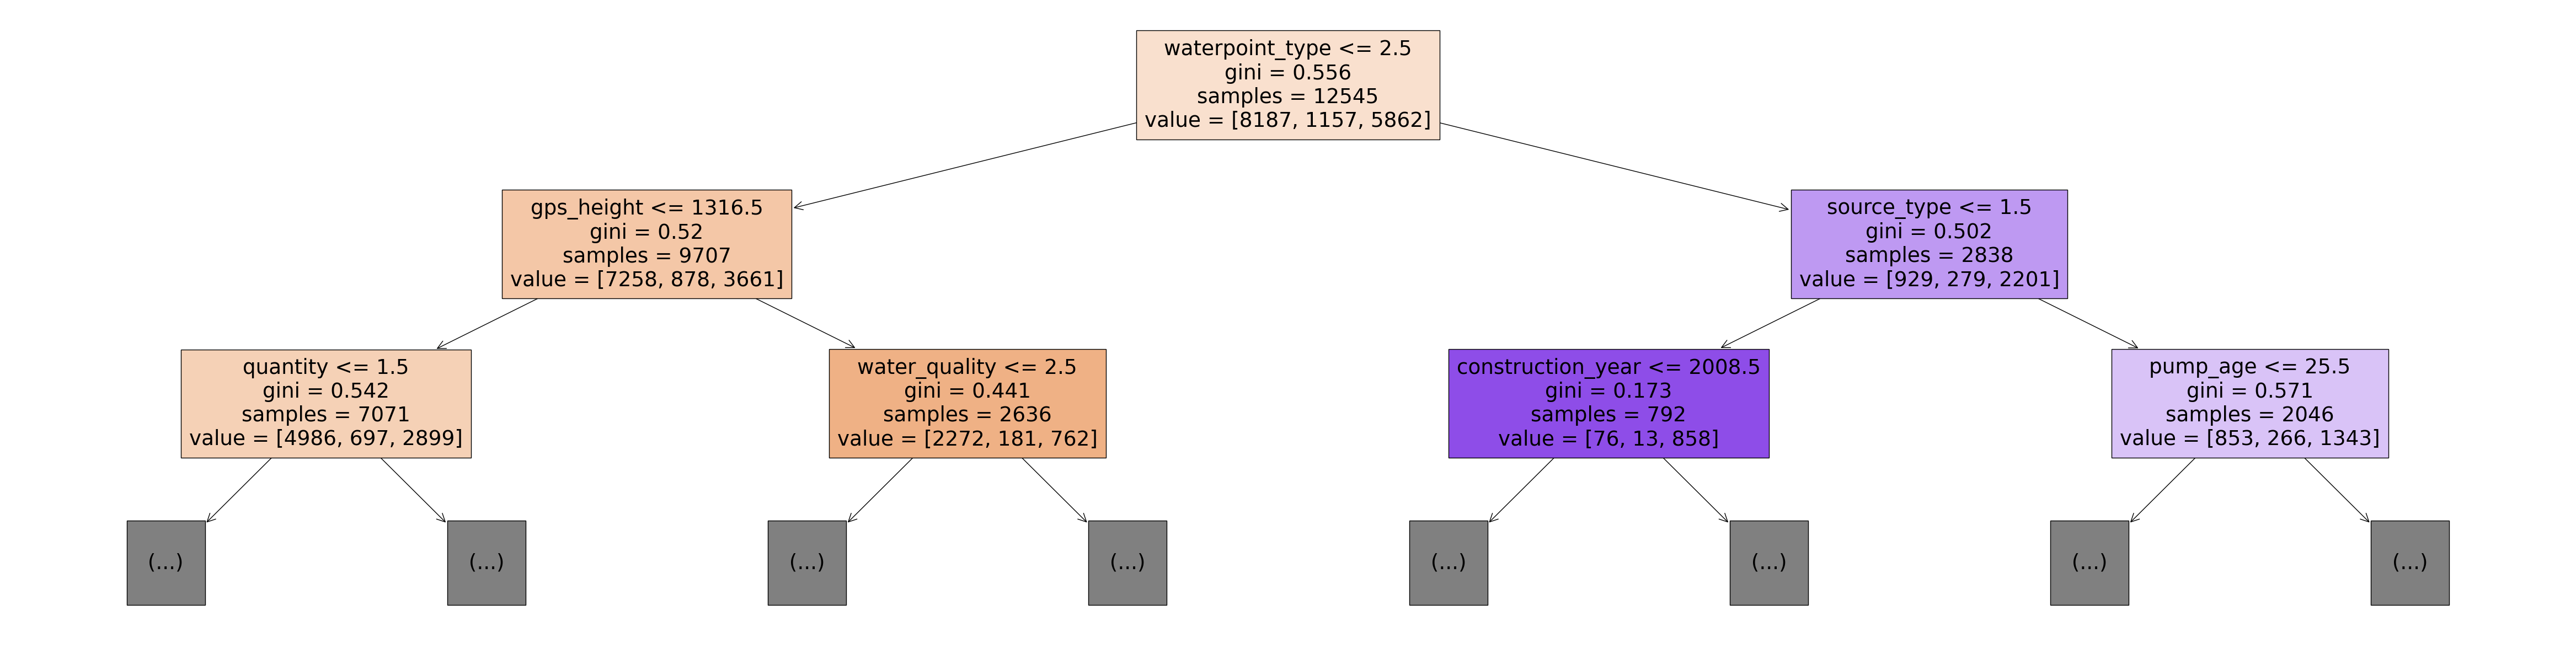

In [54]:
# plot first tree in the Random Forest
plt.figure(figsize=(60,15));
plot_tree(model_rf.named_steps['randomforestclassifier'].estimators_[0],
         max_depth=2,
         feature_names=X_train.columns,
         filled=True
         );